In [25]:
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import umap
from sklearn.cluster import KMeans

In [2]:
with open("../1_Fetal_gradcams/manual_annot_CRL_Sagittal.txt", "r") as file:
    # Read the contents of the file
    file_contents = file.read()
lines = file_contents.split('\n')
index = [int(i.split(' ')[0]) for i in lines]
labels = [' '.join(i.split(' ')[1:]) for i in lines]
manual_labels_df = pd.DataFrame()
manual_labels_df['Image ID'] = index
manual_labels_df['label'] = labels

manual_labels_df['label'] = manual_labels_df['label'].apply(lambda x: x.strip())

manual_labels_df = manual_labels_df[manual_labels_df['label'] != 'remove']

num_labels = {'head': 0, 'neck': 1, 'body': 2}

manual_labels_df['encoded_label'] = manual_labels_df['label'].map(num_labels)

y = np.array(manual_labels_df['encoded_label'])

In [3]:
imgs = np.load('../1_Fetal_gradcams/cropped_imgs_fetal_regions.npy')

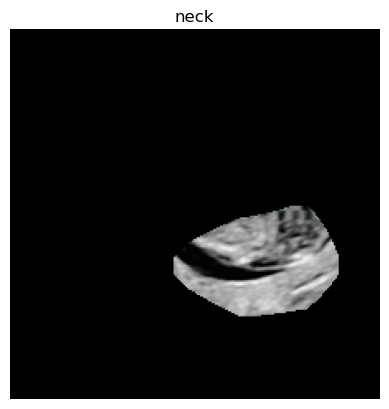

In [4]:
idx = random.randint(0, y.shape[0])
labels = {0: 'head', 1: 'neck', 2: 'body'}
plt.title(labels[y[idx]])
plt.imshow(imgs[idx])
plt.axis('off');

## Clustering using extracted features from the fully trained CNN

In [5]:
from tensorflow.keras.applications.densenet import DenseNet121
IMG_SIZE = 224
NUM_CLASSES = 3

In [6]:
def build_base_model():

    backbone_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    flat = tf.keras.layers.Flatten()(backbone_model.output)
    dense = tf.keras.layers.Dense(256, activation='relu')(flat)
    classifier = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense)

    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])

    return model

In [8]:
global_model = build_base_model()

In [9]:
for (i, l) in enumerate(global_model.layers):
    if i <= 426:
        l.trainable = False
    print(i, l.name, l.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [10]:
EPOCHS = 50
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=1e-6)
mycallbacks = [earlystop, learning_rate_reduction]

In [11]:
y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

In [12]:
from tensorflow.keras.models import load_model
global_model = load_model('full_model_fetal_classifier.h5', compile = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
global_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])

In [14]:
score = global_model.evaluate(imgs, y_onehot, verbose=0)
print("Loss:", score[0])
print("Accuracy:", score[1])

Loss: 0.023794041946530342
Accuracy: 0.9944444298744202


In [15]:
from tensorflow.keras.models import Model

base_model = global_model

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('dense').output)
model_FE.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [17]:
df_full = model_FE.predict(imgs) # extract Deep trained features for all the images

6/6 [==============================] - 1s 188ms/step


In [18]:
df_full.squeeze().shape

(180, 256)

In [23]:
umap_df = umap.UMAP(n_neighbors=5).fit_transform(df_full)

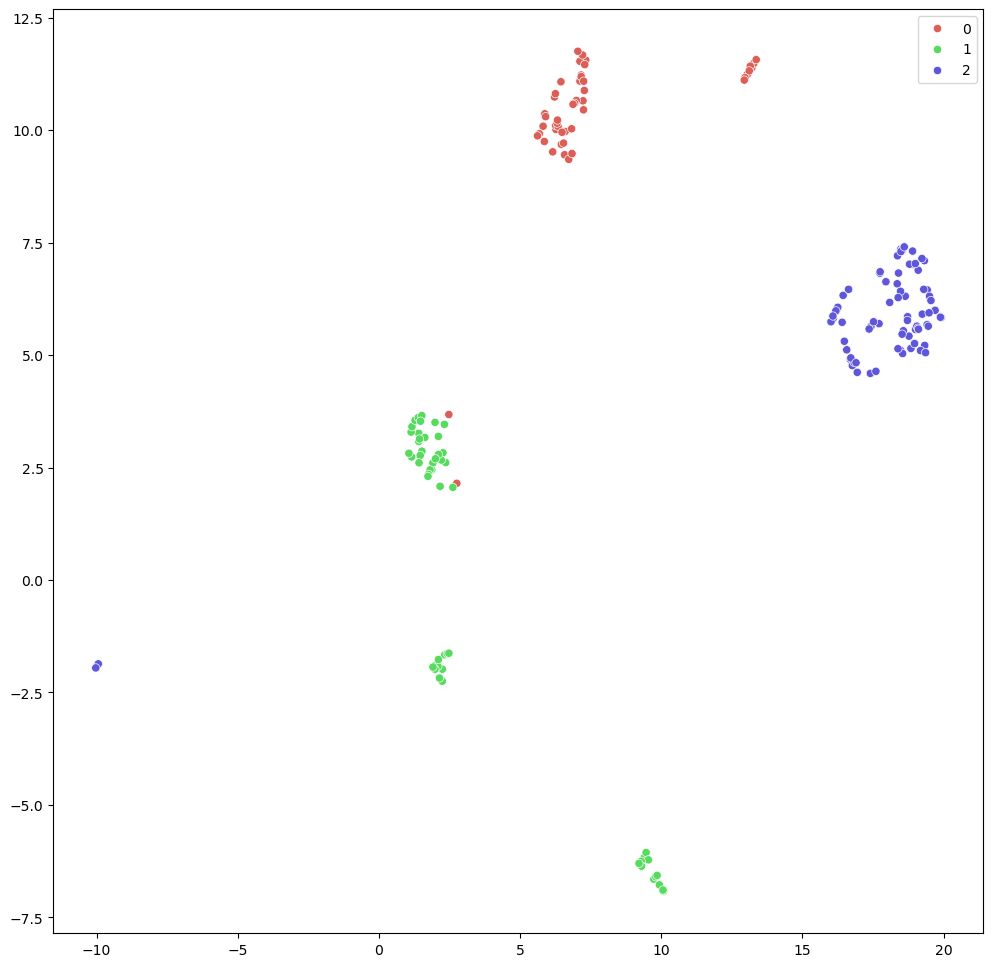

In [24]:
import seaborn as sns
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

### Applying K-Means clustering 

In [26]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_full)

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [32]:
cluster_labels = kmeans.labels_

In [33]:
cluster_labels

array([0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 1, 1,
       2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 2,
       2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1])

In [34]:
y

array([1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2,
       0, 0, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2], dtype=int64)

: 

In [30]:
from sklearn.metrics.cluster import adjusted_rand_score
print("Adjusted rand-score: ", adjusted_rand_score(cluster_labels, y))

Adjusted rand-score:  0.9859644232868635
